In [1]:
# Import Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import HistGradientBoostingClassifier as hgbc
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TunedThresholdClassifierCV
import pandas as pd
import numpy as np
import pickle, shap, warnings
warnings.filterwarnings("ignore")

c:\Users\Steven\Desktop\school github repos\development-econ\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load Dataset
df = pd.read_csv('../data/prepared_data.csv')
df.shape

(128889, 238)

In [3]:
def downcast(df, verbose = True):
    start_memory = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == "object" or 'date' in dtype_name:
            pass
        elif dtype_name == "bool":
            df[col] = df[col].astype("int8")
        elif dtype_name.startswith("int") or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast = "integer")
        else:
            df[col] = pd.to_numeric(df[col], downcast = "float")
    end_memory = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print("{:.1f}% compressed".format(100 * (start_memory - end_memory) / start_memory))
    return df
df = downcast(df)

49.4% compressed


In [4]:
y_lime = df['followed_lime_1all']
y_fert = df['followed_fert_1all']

X_pooled_basic = df[['treated','female_b','primary_all','large_shamba_b','d_young_b','ever_used_lime_b','hear_knows_lime_b','program']]

# encode program into a numeric variable
X_pooled_basic['program'] = X_pooled_basic['program'].astype('category').cat.codes
# Turn program into dummies
X_pooled_basic = pd.get_dummies(X_pooled_basic, columns=['program'], drop_first=False, dtype=int)

# Interact variables
for col in ['female_b','primary_all','large_shamba_b','d_young_b','ever_used_lime_b','hear_knows_lime_b']:
    X_pooled_basic[f'{col}_treat'] = X_pooled_basic[col] * X_pooled_basic['treated']

    for i in range(6):
        X_pooled_basic[f'{col}_program_{i}'] = X_pooled_basic[col] * X_pooled_basic[f'program_{i}']

In [5]:
df['acidity'] = 7-df['ph_prediction_b']
df['acidity_squared'] = df['acidity'] ** 2
df['farm_size'] = df['size_shamba_b']
df['farm_size_squared'] = df['farm_size'] ** 2
df['num_messages_squared'] = df['num_messages'] ** 2

In [6]:
# Training the basic model
model = hgbc(
    learning_rate=0.01,
    class_weight='balanced',
    min_samples_leaf=31,
    l2_regularization=0,
    max_features=1.0,
    max_leaf_nodes=None,
    max_depth=None,
    early_stopping=True,
    n_iter_no_change=100,
    scoring='roc_auc',
    verbose=1,
    max_iter = 2000,
    random_state=42
)

model.fit(X_pooled_basic, y_lime)
pickle.dump(model, open('../output/models/basic_model_lime.pkl', 'wb'))
print(f"Basic Model AUROC: {roc_auc_score(y_lime, model.predict_proba(X_pooled_basic)[:, 1])}")

Binning 0.051 GB of training data: 0.036 s
Binning 0.006 GB of validation data: 0.002 s
Fitting gradient boosted rounds:
Fit 114 trees in 4.599 s, (16443 total leaves)
Time spent computing histograms: 1.358s
Time spent finding best splits:  0.186s
Time spent applying splits:      0.421s
Time spent predicting:           0.024s
Basic Model AUROC: 0.8109355429105938


In [7]:
# Optimal balanced accuracy
calibration = TunedThresholdClassifierCV(
    model,
    scoring='balanced_accuracy',
    cv='prefit',
    refit=False,
    random_state=1234
    ).fit(X_pooled_basic, y_lime)

print("Optimal threshold:", calibration.best_threshold_)
print(f"Best balanced accuracy: {balanced_accuracy_score(y_lime, calibration.predict(X_pooled_basic))}")

Optimal threshold: 0.5147618075741767
Best balanced accuracy: 0.7701330506697739


In [8]:
X_pooled_large = df[['treated','female_b','primary_all','ever_used_lime_b','hear_knows_lime_b','program','family_treatment',
'farm_size','farm_size_squared','age_decades','age_squared','num_messages','num_messages_squared','acidity','acidity_squared']]

# encode program into a numeric variable
X_pooled_large['program'] = X_pooled_large['program'].astype('category').cat.codes
# Turn program into dummies
X_pooled_large = pd.get_dummies(X_pooled_large, columns=['program'], drop_first=False, dtype=int)

# Split Data into Training and Testing Sets
X = X_pooled_large
y = y_lime

# Rescale the numeric columns
cols_to_rescale = ['farm_size','farm_size_squared','age_decades','age_squared','num_messages','num_messages_squared','acidity','acidity_squared']
scaler = MinMaxScaler()
X[cols_to_rescale] = scaler.fit_transform(X[cols_to_rescale])

# Interact variables
for col in ['female_b','primary_all','ever_used_lime_b','hear_knows_lime_b','family_treatment','farm_size','farm_size_squared','age_decades','age_squared','num_messages','num_messages_squared','acidity','acidity_squared']:
    X[f'{col}_treat'] = X[col] * X['treated']

# Additional interactions
# female
for col in ['primary_all','ever_used_lime_b','hear_knows_lime_b','family_treatment','farm_size','farm_size_squared','age_decades','age_squared','num_messages','num_messages_squared','acidity','acidity_squared']:
    X[f'{col}_female'] = X[col] * X['female_b']

# Used lime before
for col in ['primary_all','farm_size','farm_size_squared','age_decades','age_squared','num_messages','num_messages_squared']:
    X[f'{col}_lime_before'] = X[col] * X['ever_used_lime_b']

In [9]:
# Training large model
model = hgbc(
    learning_rate=0.01,
    class_weight='balanced',
    min_samples_leaf=100,
    l2_regularization=0,
    max_features=1.0,
    max_leaf_nodes=None,
    max_depth=None,
    early_stopping=True,
    n_iter_no_change=100,
    scoring='roc_auc',
    verbose=1,
    max_iter = 2000,
    random_state=42
)

model.fit(X, y)
print(f"Large Model AUROC: {roc_auc_score(y, model.predict_proba(X)[:, 1])}")

Binning 0.048 GB of training data: 0.035 s
Binning 0.005 GB of validation data: 0.002 s
Fitting gradient boosted rounds:
Fit 237 trees in 9.413 s, (69800 total leaves)
Time spent computing histograms: 3.947s
Time spent finding best splits:  0.780s
Time spent applying splits:      1.303s
Time spent predicting:           0.066s
Large Model AUROC: 0.8429582895851347


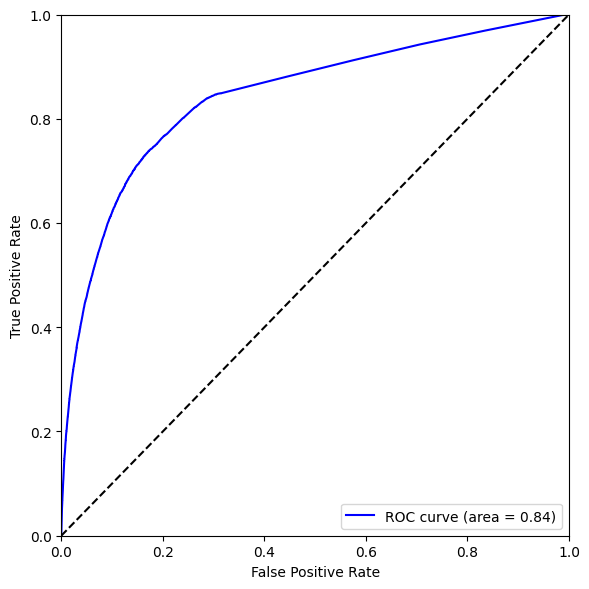

In [10]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('../output/lightgbm_roc_lime.pdf')

In [11]:
# Optimal balanced accuracy
calibration = TunedThresholdClassifierCV(
    model,
    scoring='balanced_accuracy',
    cv='prefit',
    refit=False,
    random_state=1234
    ).fit(X, y)

pickle.dump(calibration, open('../output/models/large_model_lime.pkl', 'wb'))
print("Optimal threshold:", calibration.best_threshold_)
print(f"Best balanced accuracy: {balanced_accuracy_score(y, calibration.predict(X))}")

Optimal threshold: 0.574656402015251
Best balanced accuracy: 0.7829627046795491


In [22]:
# sample 1000 rows from x_eval
x_sample = X.sample(n=1000, random_state=1234)
# shap values
explainer = shap.TreeExplainer(model, x_sample, feature_names=X_pooled_large.columns, model_output='probability')
shap_values = explainer(x_sample, check_additivity=True)

 94%|=================== | 939/1000 [00:16<00:01]       

In [23]:
preds = model.predict_proba(x_sample)[:,1]
# Which index has the highest predicted probability
max_prob = preds.argmax()
min_prob = preds.argmin()

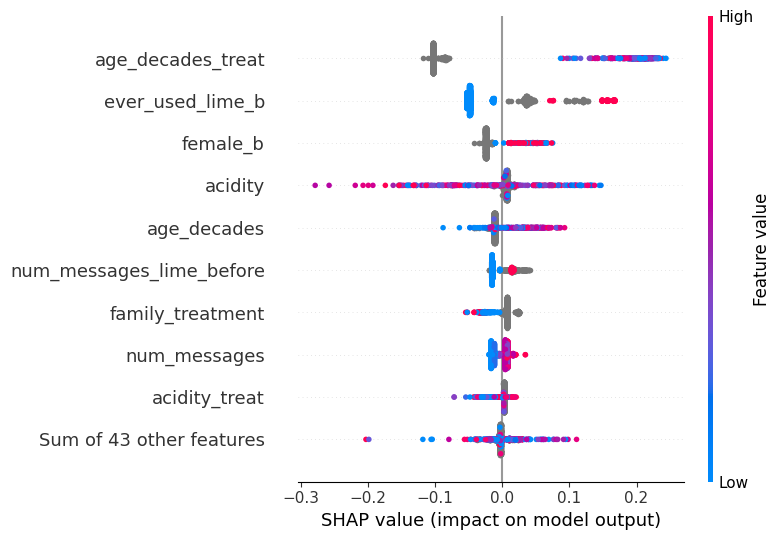

In [24]:
fig = plt.figure(figsize=(10, 15))
fig.add_axes(shap.plots.beeswarm(shap_values, max_display=10, show=False))
fig.tight_layout()
fig.savefig('../output/shap_beeswarm_lime.pdf')

In [25]:
x_sample_plot = x_sample.copy()
x_sample_plot[cols_to_rescale] = scaler.inverse_transform(x_sample_plot[cols_to_rescale])

In [28]:
plot_df = {
    'feature': x_sample.columns.to_list(),
    'feature_value': x_sample_plot.iloc[max_prob,:].values,
    'shap_value': shap_values[max_prob].values,
    'baseline': [shap_values[max_prob].base_values]*len(x_sample.columns)
}

plot_df = pd.DataFrame(plot_df)
plot_df = plot_df[np.abs(plot_df['shap_value'])>0.01]
plot_df.sort_values(by='shap_value', inplace=True)
plot_df.reset_index(drop=True, inplace=True)
plot_df['cum_shap'] = plot_df['shap_value'].cumsum()
plot_df['cum_shap'] = (plot_df['cum_shap'] + plot_df['baseline']) * 100

# Clean names
plot_df['feature'] = np.where(plot_df['feature']=='acidity_treat', 'Soil Acidity x Treated', plot_df['feature'])
plot_df['feature'] = np.where(plot_df['feature']=='family_treatment', 'Family-Oriented Text', plot_df['feature'])
plot_df['feature'] = np.where(plot_df['feature']=='ever_used_lime_b', 'Used Lime Before', plot_df['feature'])
plot_df['feature'] = np.where(plot_df['feature']=='num_messages_lime_before', '# Texts x Used Lime Before', plot_df['feature'])
plot_df['feature'] = np.where(plot_df['feature']=='female_b', 'Female', plot_df['feature'])
plot_df['feature'] = np.where(plot_df['feature']=='age_decades_female', 'Age (Decades) x Female', plot_df['feature'])
plot_df['feature'] = np.where(plot_df['feature']=='acidity', 'Soil Acidity', plot_df['feature'])
plot_df['feature'] = np.where(plot_df['feature']=='acidity_female', 'Soil Acidity x Female', plot_df['feature'])
plot_df['feature'] = np.where(plot_df['feature']=='age_decades', 'Age (Decades)', plot_df['feature'])
plot_df['feature'] = np.where(plot_df['feature']=='age_decades_treat', 'Age (Decades) x Treated', plot_df['feature'])

acid = plot_df[plot_df['feature']=='Soil Acidity']['feature_value'].values
age  = plot_df[plot_df['feature']=='Age (Decades)']['feature_value'].values

plot_df['feature_value'] = np.where(plot_df['feature']=='Soil Acidity x Treated', acid, plot_df['feature_value'])
plot_df['feature_value'] = np.where(plot_df['feature']=='Soil Acidity x Female', acid, plot_df['feature_value'])
plot_df['feature_value'] = np.where(plot_df['feature']=='Age (Decades) x Treated', age, plot_df['feature_value'])
plot_df['feature_value'] = np.where(plot_df['feature']=='Age (Decades) x Female', age, plot_df['feature_value'])

plot_df['label'] = plot_df['feature'] + ' (=' + plot_df['feature_value'].round(2).astype(str) + ')'

plot_df.loc[-1] = ['Baseline Odds', 0,0,0,100*shap_values[max_prob].base_values,'Baseline Odds']
plot_df.sort_index(inplace=True)
plot_df

,feature,feature_value,shap_value,baseline,cum_shap,label
-1,Baseline Odds,0.000000,0.000000,0.000000,40.399186,Baseline Odds
0,Family-Oriented Text,0.000000,-0.010988,0.403992,39.300391,Family-Oriented Text (=0.0)
1,Soil Acidity x Female,1.557214,0.013436,0.403992,40.643986,Soil Acidity x Female (=1.56)
2,Age (Decades) x Female,5.800000,0.014227,0.403992,42.066646,Age (Decades) x Female (=5.8)
3,# Texts x Used Lime Before,NaN,0.033384,0.403992,45.405035,# Texts x Used Lime Before (=nan)
4,Used Lime Before,NaN,0.037626,0.403992,49.167674,Used Lime Before (=nan)
5,Female,1.000000,0.048106,0.403992,53.978257,Female (=1.0)
6,Age (Decades),5.800000,0.057750,0.403992,59.753208,Age (Decades) (=5.8)
7,Soil Acidity,1.557214,0.147115,0.403992,74.464736,Soil Acidity (=1.56)
8,Age (Decades) x Treated,5.800000,0.185046,0.403992,92.969313,Age (Decades) x Treated (=5.8)


In [31]:
plot_df2 = {
    'feature': x_sample.columns.to_list(),
    'feature_value': x_sample_plot.iloc[min_prob,:].values,
    'shap_value': shap_values[min_prob].values,
    'baseline': [shap_values[min_prob].base_values]*len(x_sample.columns)
}
plot_df2 = pd.DataFrame(plot_df2)
plot_df2 = plot_df2[np.abs(plot_df2['shap_value'])>0.005]
plot_df2.sort_values(by='shap_value', inplace=True, ascending=False)
plot_df2.reset_index(drop=True, inplace=True)
plot_df2['cum_shap'] = plot_df2['shap_value'].cumsum()
plot_df2['cum_shap'] = (plot_df2['cum_shap'] + plot_df2['baseline']) * 100
# Clean names
plot_df2['feature'] = np.where(plot_df2['feature']=='acidity_treat', 'Soil Acidity x Treated', plot_df2['feature'])
plot_df2['feature'] = np.where(plot_df2['feature']=='family_treatment', 'Family-Oriented Text', plot_df2['feature'])
plot_df2['feature'] = np.where(plot_df2['feature']=='num_messages', '# Texts', plot_df2['feature'])
plot_df2['feature'] = np.where(plot_df2['feature']=='program_2', 'Program 2 Indicator', plot_df2['feature'])
plot_df2['feature'] = np.where(plot_df2['feature']=='ever_used_lime_b', 'Used Lime Before', plot_df2['feature'])
plot_df2['feature'] = np.where(plot_df2['feature']=='num_messages_lime_before', '# Texts x Used Lime Before', plot_df2['feature'])
plot_df2['feature'] = np.where(plot_df2['feature']=='female_b', 'Female', plot_df2['feature'])
plot_df2['feature'] = np.where(plot_df2['feature']=='age_decades_female', 'Age (Decades) x Female', plot_df2['feature'])
plot_df2['feature'] = np.where(plot_df2['feature']=='acidity', 'Soil Acidity', plot_df2['feature'])
plot_df2['feature'] = np.where(plot_df2['feature']=='acidity_female', 'Soil Acidity x Female', plot_df2['feature'])
plot_df2['feature'] = np.where(plot_df2['feature']=='age_decades', 'Age (Decades)', plot_df2['feature'])
plot_df2['feature'] = np.where(plot_df2['feature']=='age_decades_treat', 'Age (Decades) x Treated', plot_df2['feature'])
acid = plot_df2[plot_df2['feature']=='Soil Acidity']['feature_value'].values
plot_df2['feature_value'] = np.where(plot_df2['feature']=='Soil Acidity x Treated', acid, plot_df2['feature_value'])
plot_df2['label'] = plot_df2['feature'] + ' (=' + plot_df2['feature_value'].round(2).astype(str) + ')'
plot_df2.loc[-1] = ['Baseline Odds', 0,0,0,100*shap_values[max_prob].base_values,'Baseline Odds']
plot_df2.sort_index(inplace=True)
plot_df2

,feature,feature_value,shap_value,baseline,cum_shap,label
-1,Baseline Odds,0.000000,0.000000,0.000000,40.399186,Baseline Odds
0,Used Lime Before,NaN,0.008551,0.403992,41.254325,Used Lime Before (=nan)
1,# Texts,10.000000,0.005144,0.403992,41.768676,# Texts (=10.0)
2,Program 2 Indicator,1.000000,-0.007400,0.403992,41.028659,Program 2 Indicator (=1.0)
3,Soil Acidity x Treated,1.681668,-0.008623,0.403992,40.166361,Soil Acidity x Treated (=1.68)
4,Soil Acidity x Female,NaN,-0.010843,0.403992,39.082082,Soil Acidity x Female (=nan)
5,# Texts x Used Lime Before,NaN,-0.019207,0.403992,37.161385,# Texts x Used Lime Before (=nan)
6,Female,NaN,-0.034552,0.403992,33.706198,Female (=nan)
7,Age (Decades),NaN,-0.039128,0.403992,29.793403,Age (Decades) (=nan)
8,Family-Oriented Text,1.000000,-0.051544,0.403992,24.639016,Family-Oriented Text (=1.0)


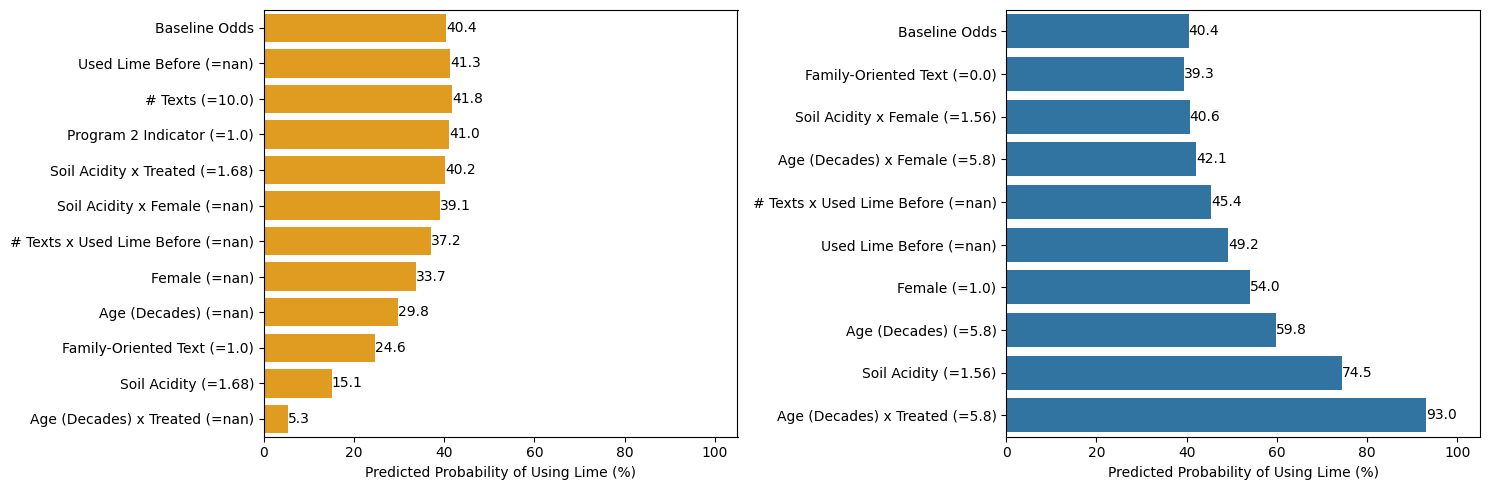

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

sns.barplot(data=plot_df2, x='cum_shap', y='label', color='orange', ax=axes[0])
axes[0].set_xlabel('Predicted Probability of Using Lime (%)')
axes[0].set_ylabel('')
axes[0].set_xlim(0, 105)
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.1f')

sns.barplot(data=plot_df, x='cum_shap', y='label', ax=axes[1])
axes[1].set_xlabel('Predicted Probability of Using Lime (%)')
axes[1].set_ylabel('')
axes[1].set_xlim(0, 105)
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.1f')

plt.tight_layout()
plt.savefig('../output/shap_forceplot_examples_lime.pdf')